# Download representative images of volcanos


Credit: this script derived from [Aaron Geller's blog post.](https://sites.northwestern.edu/researchcomputing/2021/11/19/downloading-satellite-images-made-easy/), including the use of functions based on his [EarthEngineToGeoTIFF repository.](https://github.com/ageller/EarthEngineToGeoTIFF)

In [1]:
import ee
%pip install rasterio

import rasterio
from rasterio.plot import show as showRasterio

import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import zipfile
import os
import requests

import numpy as np

def getSentinalS2SRImage(lon, lat, sze_km, filename, dateMin = '2020-04-01', dateMax = '2020-04-30', vmin = 0, vmax = 3500):
    '''    
    download an RGB image from the Sentinal S2 Surface Reflectance satellite, at the given coordinates
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze_km : size of the edge of the box in km
    dateMin : minimum date to use for image search in year-month-day (e.g., 2020-08-01)
    dateMax : maximum date to use for image search in year-month-day (e.g., 2020-08-31)
    vMin : minimum value to select in the Sentinal image pixels (I think this should be close to 0)
    vMax : maximum value to select in the Sentinal image pixels (I think this should be close to 3000)
    filename : output filename for the GeoTIFF image
    
    Note: it's possible that the vMin and vMax values should be different for each band to make the image look nicer
    
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    '''


    print('Downloading Sentinel S2 Surface Reflectance satellite images ... ')
    
    # define the area of interest, using the Earth Engines geometry object

    pt = ee.Geometry.Point(lon,lat)
    
    aoi = ee.Geometry.buffer(pt,sze_km)

    # get the image using Google's Earth Engine
    db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')\
                       .filterBounds(aoi)\
                       .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                       .sort('CLOUDY_PIXEL_PERCENTAGE')\
                       .first())
    
    # add the latitude and longitude
    db = db.addBands(ee.Image.pixelLonLat())

    # define the bands that I want to use.  B4 is red, B3 is green, B2 is blue
    # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands
    bands = ['B4', 'B3', 'B2']

    # export geotiff images, these go to Drive and then are downloaded locally
    for selection in bands:
        task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                     description=selection,
                                     scale=30,
                                     region=aoi,
                                     fileNamePrefix=selection,
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
        task.start()

        url = db.select(selection).getDownloadURL({
            'scale': 30,
            'crs': 'EPSG:4326',
            'fileFormat': 'GeoTIFF',
            'region': aoi})
    
        r = requests.get(url, stream=True)

        filenameZip = selection+'.zip'
        filenameTif = selection+'.tif'

        # unzip and write the tif file, then remove the original zip file
        with open(filenameZip, "wb") as fd:
            for chunk in r.iter_content(chunk_size=1024):
                fd.write(chunk)

        zipdata = zipfile.ZipFile(filenameZip)
        zipinfos = zipdata.infolist()

        # iterate through each file (there should be only one)
        for zipinfo in zipinfos:
            zipinfo.filename = filenameTif
            zipdata.extract(zipinfo)
    
        zipdata.close()
        
    # create a combined RGB geotiff image
    # https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
    print('Creating 3-band GeoTIFF image ... ')
    
    # open the images
    B2 = rasterio.open('B2.tif')
    B3 = rasterio.open('B3.tif')
    B4 = rasterio.open('B4.tif')

    # get the scaling
    image = np.array([B2.read(1), B3.read(1), B4.read(1)]).transpose(1,2,0)
    p2, p98 = np.percentile(image, (2,98))

    # use the B2 image as a starting point so that I keep the same parameters
    B2_geo = B2.profile
    B2_geo.update({'count': 3})

    with rasterio.open(filename, 'w', **B2_geo) as dest:
        dest.write( (np.clip(B4.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
        dest.write( (np.clip(B3.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
        dest.write( (np.clip(B2.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

    B2.close()
    B3.close()
    B4.close()
    
    # remove the intermediate files
    for selection in bands:
        os.remove(selection + '.tif')
        os.remove(selection + '.zip')
  


In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=DJOVlMak4hzbMFXrY0kI2l774dAMIJ7UxSda0rRkz1w&tc=JHtfaT6004SGuQyHOj_Rthca-qAFO8NzGTh8mglcWTs&cc=TO-muudtC41P150_5b1AQSYD_laUQWgRB48_RBZzzqk

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhw-ekGFOQZztQipyQ7eoHA05acuymDraacjHtYIqkEmlaxO4drpxE

Successfully saved authorization token.


In [4]:
# connect to google drive
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)

targets = pd.read_excel("/content/drive/My Drive/Volcano_datasets/Sample Eruptions.xlsx")

image_directory = "/content/drive/My Drive/Volcano_datasets/Satellite_images/"

Mounted at /content/drive


1 /content/drive/My Drive/Volcano_datasets/Satellite_images/360150_Soufriere_St_Vincent_22385_2020-12-27
Creating 3-band GeoTIFF image ... 
2 /content/drive/My Drive/Volcano_datasets/Satellite_images/344020_San_Cristobal_22394_2020-12-27
Creating 3-band GeoTIFF image ... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


3 /content/drive/My Drive/Volcano_datasets/Satellite_images/263310_Tengger_Caldera_22382_2020-12-26
Creating 3-band GeoTIFF image ... 
4 /content/drive/My Drive/Volcano_datasets/Satellite_images/332010_Kilauea_22380_2020-12-20
Creating 3-band GeoTIFF image ... 
5 /content/drive/My Drive/Volcano_datasets/Satellite_images/233020_Fournaise_Piton_de_la_22371_2020-12-7
Creating 3-band GeoTIFF image ... 
6 /content/drive/My Drive/Volcano_datasets/Satellite_images/264230_Lewotolok_22373_2020-11-27
Creating 3-band GeoTIFF image ... 
7 /content/drive/My Drive/Volcano_datasets/Satellite_images/282060_Kikai_22374_2020-10-6


EEException: ignored

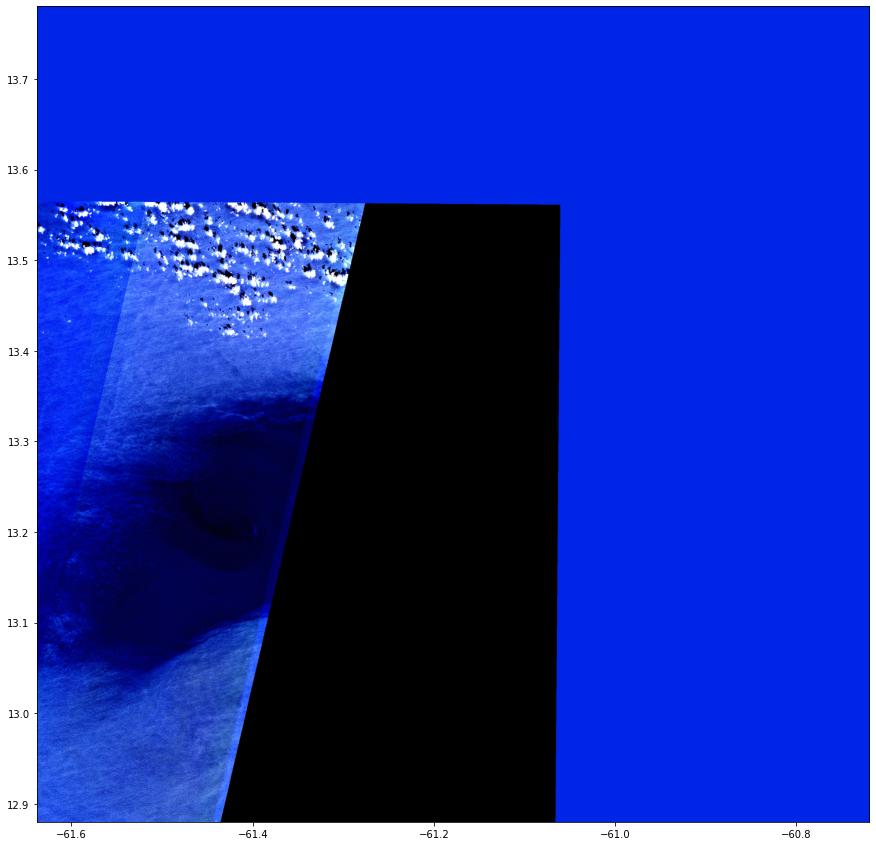

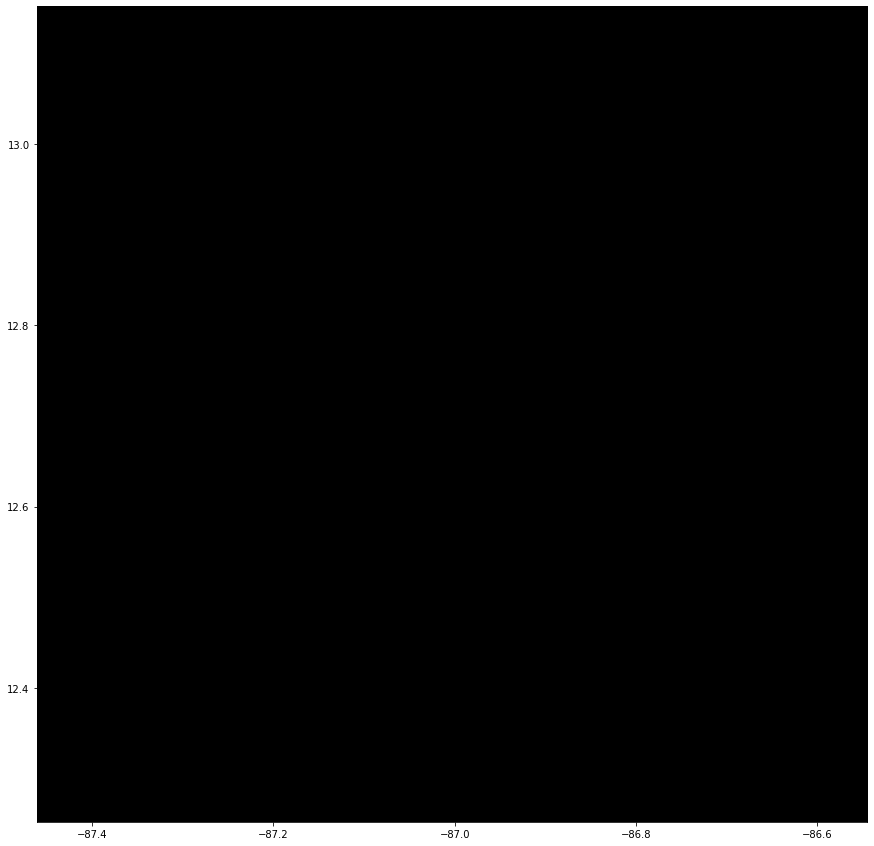

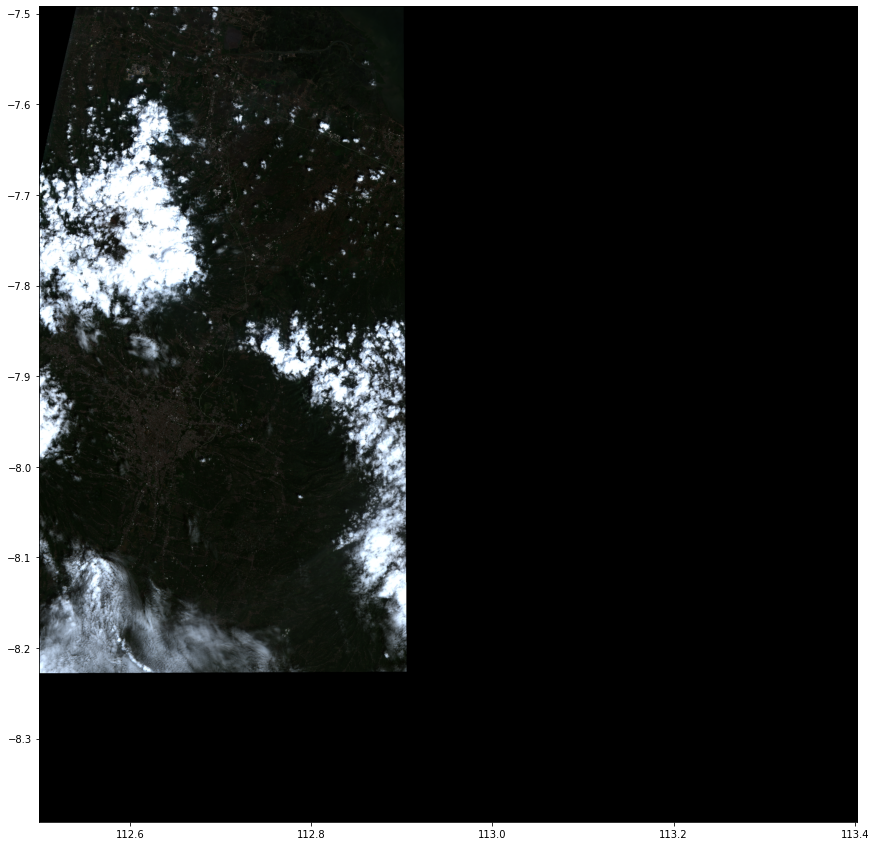

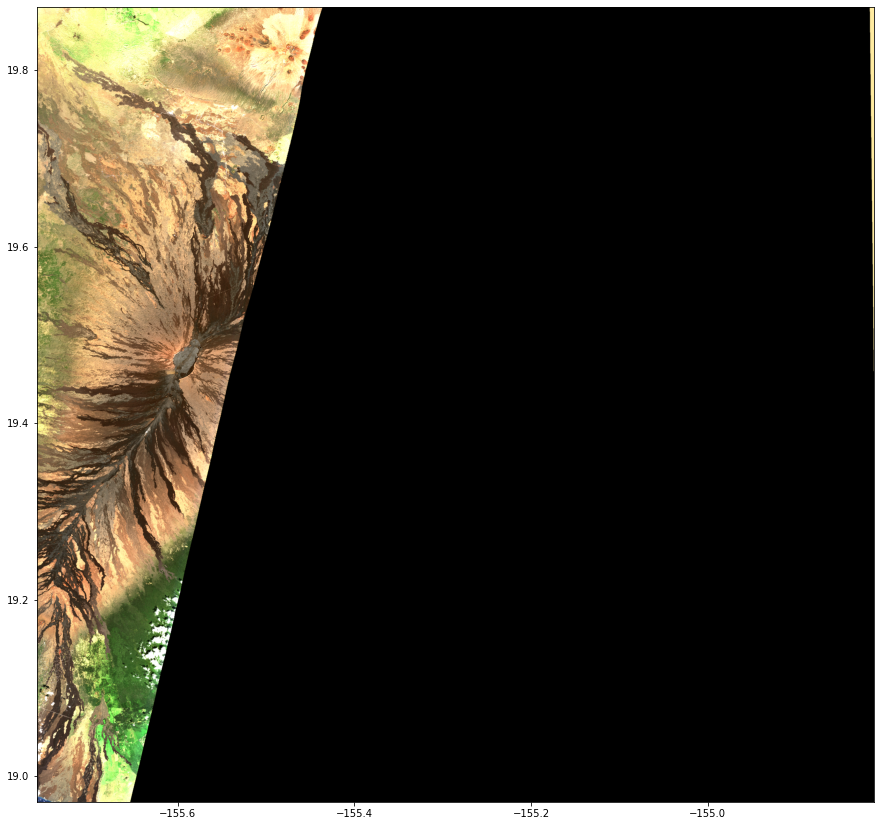

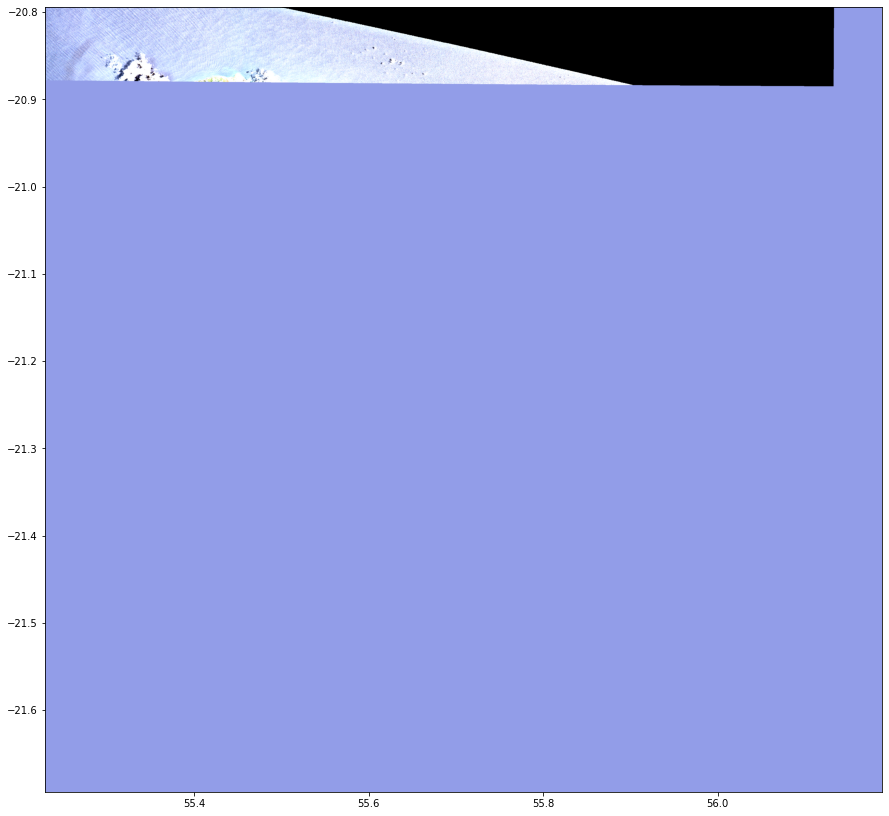

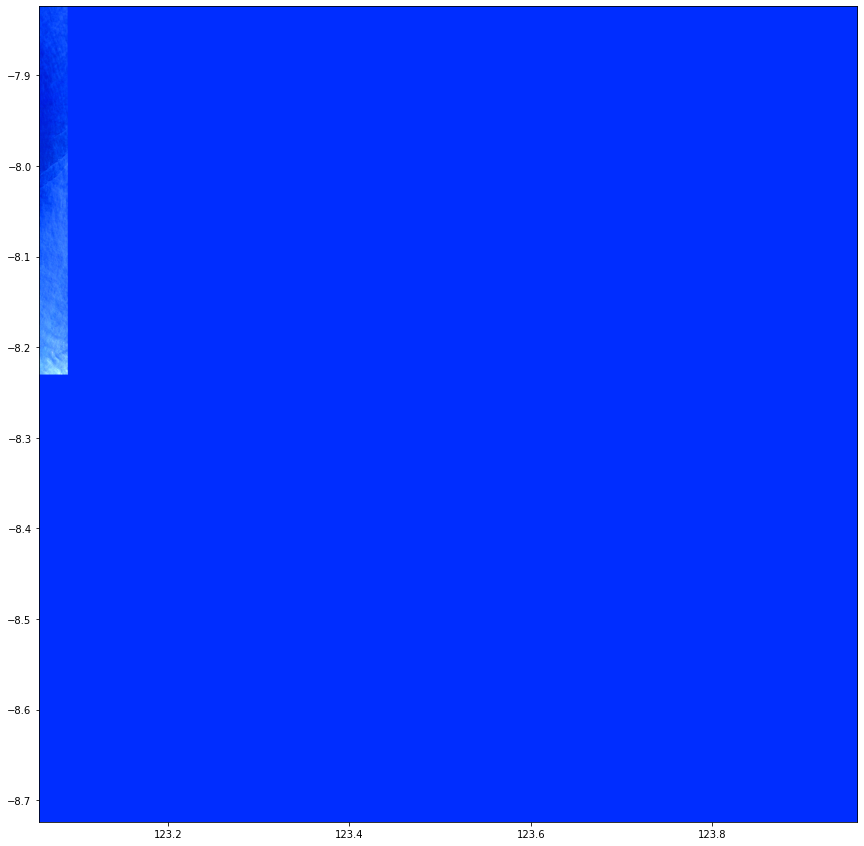

In [10]:


target_size_km = 50000
for i_eruption in range(1,targets.shape[0]):
    volc = targets.loc[i_eruption]
    v_name = re.sub(r"[,.]","",re.sub(r"\s+", "_",volc["Volcano Name"]))
    date =volc["Start Date"]
    volc_file_name = f'{image_directory}{volc["Volcano Number"]}_{v_name}_{volc["Eruption Number"]}_{date}'

    print(i_eruption, volc_file_name)
      # just get one for now

    _ = getSentinalS2SRImage(volc["Longitude"], volc["Latitude"], target_size_km,volc_file_name+".tif", 
                             dateMin = volc["Start Date"], dateMax = volc["End Date"])

    f,ax = plt.subplots(figsize=(15,15))

    img = rasterio.open(volc_file_name+".tif")

    showRasterio(img.read(), ax = ax, transform=img.transform)

    f.savefig(volc_file_name+".png", bbox_inches='tight')

    img.close()

    os.remove(volc_file_name+".tif")